# IMIL-3D: Image Manipulation Interpretation Lab 3D

> _A Python framework for converting single 2D images into textured 3D mesh reconstructions._

Welcome to 3D IMIL a lab created in collaboration by undergrad Samuel Chavez F. in supervision by PhD. Nelson Baloian and inspired and direction of MSc. Cristian Llull.

The module lab presents the foundations of working with single images in Python to streamline the process of interpreting a static image and infere depth to recreate good fidelity 3D estimations of the object using different methods initially in the scope of culture presevation and digitalization of Khachkars

Next is presented a interactive documentation of what you can find in this lab, in conjuction with this docs there is main as example pipeline end to end that uses the methods to get a object reconstruction.


<div class="centered">
    <img src="../Assets/Khachckars/1.jpg" width="300">
</div>

In [3]:
# Setup - Run this cell first
import numpy as np
import matplotlib.pyplot as plt
import imil_3d as im3

# Configuration
IMG_PATH = "../Assets/Khachckars/1.jpg"
IMG_RES = 0.1  # Megapixels (lower = faster for demos)

# SAM2 paths (adjust if needed)
CHECKPOINT_DIR = "../checkpoints"
SAM2_PT = f"{CHECKPOINT_DIR}/sam2.1_hiera_base_plus.pt"
SAM2_CFG = "configs/sam2.1/sam2.1_hiera_b+.yaml"

# Load example image
img_arr = im3.functions.image_open(IMG_PATH)
img_arr = im3.field_manipulation.image_resize(img_arr, mp=IMG_RES)

plt.figure(figsize=(6, 8))
plt.imshow(img_arr)
plt.title(f"Example Image: Khachkar 1 ({img_arr.shape[1]}x{img_arr.shape[0]})")
plt.axis('off')
plt.show()

print(f"✓ Image loaded: {img_arr.shape}")


ModuleNotFoundError: No module named 'utils'

# Features

## Imiltyping: Backbone of contracts

The `imiltyping` module defines type aliases using `nptyping` for strong typing throughout the codebase:

| Type | Description |
|------|-------------|
| `ListPoint2D` | Array of 2D points `(N, 2)` |
| `BoolField2D` | 2D boolean mask `(H, W)` |
| `NumberField2D` | 2D numeric array `(H, W)` |
| `ImageLikeArray` | Image arrays (Gray, LA, RGB, RGBA) |
| `NumerPoint3D` | 3D point `(3,)` |

These types enable IDE autocompletion and runtime validation. And are key to complete the contracts that make this Lab functional and flexible to make it a pipeline.


## Field Recognition: Identifying in an image

This module handles object detection and segmentation:

### Key Functions:
- **`sam_mask()` / `sam2_mask()`** - Segment objects using SAM/SAM2 with a bounding box
- **`corners_rect()`** - Find corners via minimum area rectangle fitting
- **`corners_hough()`** - Find corners using Hough line transform
- **`corners_rdp()`** - Find corners using Ramer-Douglas-Peucker algorithm


Bounding box: [[ 45  15]
 [210 355]]


/home/fx-samu/Documents/GitHub/3D-IMIL/.venv/lib/python3.13/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/im3/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


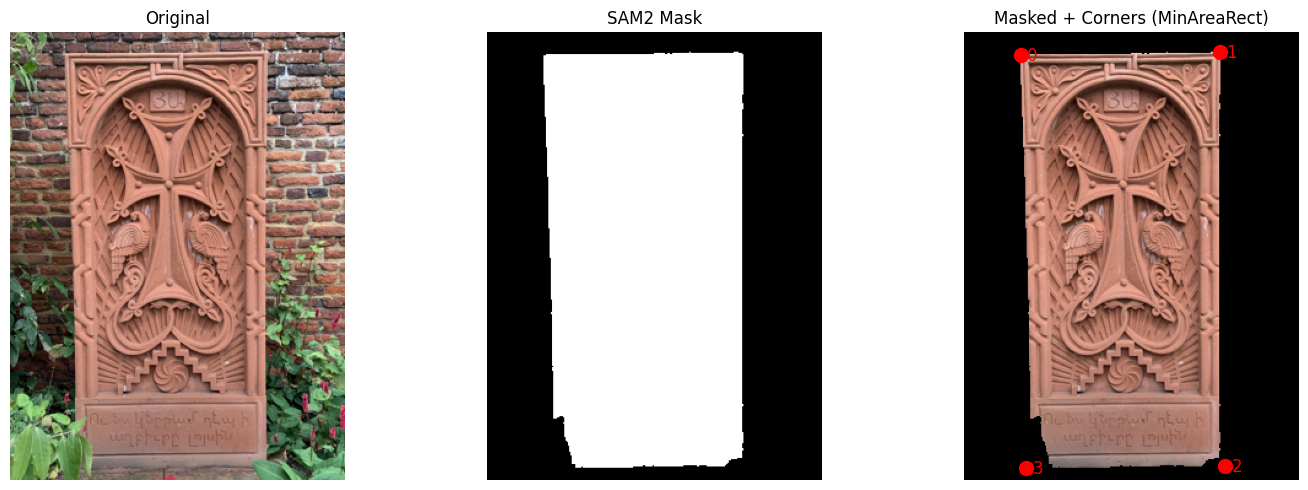

Detected corners:
[[ 45.674553  17.591003]
 [207.96571   15.427124]
 [212.46323  352.7405  ]
 [ 50.172073 354.9044  ]]


In [ ]:
# Field Recognition Example: SAM2 Segmentation + Corner Detection

# Get bounding box for image 1 at 0.5MP
bbox = im3.field_recognition.magic_bounding_box(1, IMG_RES)
print(f"Bounding box: {bbox}")

# Segment with SAM2 (requires GPU)
mask = im3.field_recognition.sam2_mask(img_arr, bbox, SAM2_PT, SAM2_CFG)

# Apply mask to image
img_masked = im3.field_manipulation.field_mask(img_arr, mask)

# Detect corners using three different methods
corners_rect = im3.field_recognition.corners_rect(img_masked)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_arr)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("SAM2 Mask")
axes[1].axis('off')

axes[2].imshow(img_masked)
# Draw detected corners
for i, corner in enumerate(corners_rect):
    axes[2].plot(corner[0], corner[1], 'ro', markersize=10)
    axes[2].annotate(str(i), (corner[0]+5, corner[1]+5), color='red', fontsize=12)
axes[2].set_title("Masked + Corners (MinAreaRect)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Detected corners:\n{corners_rect}")


## Field Manipulation: Modifying that Image

Image processing utilities for preparing data:

### Key Functions:
- **`image_resize(img, mp)`** - Resize to target megapixels
- **`field_mask(img, mask)`** - Apply boolean mask to image
- **`unwarp(img, corners)`** - Perspective correction using 4 corners
- **`map_unwarp(img, corners)`** - Auto-orient corners + unwarp
- **`field_normalization(field)`** - Normalize values to [0, 1]
- **`field_normalization_mask(field, mask)`** - Normalize only masked region


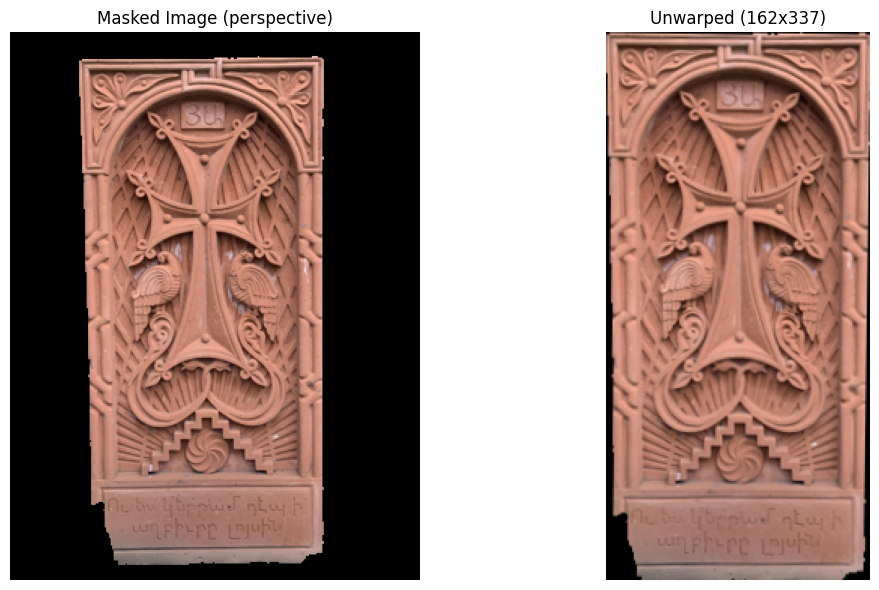

Unwarped shape: (337, 162, 3)


In [ ]:
# Field Manipulation Example: Perspective Unwarp

# Unwarp the masked image using detected corners
unwarp_img = im3.field_manipulation.map_unwarp(img_masked, corners_rect)

# Visualize the transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_masked)
axes[0].set_title("Masked Image (perspective)")
axes[0].axis('off')

axes[1].imshow(unwarp_img)
axes[1].set_title(f"Unwarped ({unwarp_img.shape[1]}x{unwarp_img.shape[0]})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Unwarped shape: {unwarp_img.shape}")


## Height Map: Inference of depth from an Image

Simple depth estimation from image luminance:

### Key Functions:
- **`grayscale(img)`** - Convert to grayscale with autocontrast as depth proxy

*Note: This is a simplified approach. For better results, consider using neural depth estimation models like Depth Anything or MiDaS.*


In [ ]:
# Height Map Example: Generate depth from grayscale

# Convert to height map
height_map = im3.height_map.grayscale(unwarp_img)
final_mask = height_map != 0

# Normalize the height map within the mask
norm_hmap = im3.field_manipulation.field_normalization_mask(height_map, final_mask)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(unwarp_img)
axes[0].set_title("Unwarped Image")
axes[0].axis('off')

axes[1].imshow(height_map, cmap='gray')
axes[1].set_title("Height Map (grayscale)")
axes[1].axis('off')

im = axes[2].imshow(norm_hmap, cmap='viridis')
axes[2].set_title("Normalized Height Map")
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Height map range: [{norm_hmap.min():.3f}, {norm_hmap.max():.3f}]")


Height map range: [0.000, 1.000]


## Mesh Works: Making it real

Convert height maps to textured 3D meshes:

### Key Functions:
- **`mesh_hmap(height_map)`** - Create triangulated mesh from 2D height map
- **`face_mask_from_vertex_mask(mesh, mask)`** - Convert vertex mask to face mask
- **`mask_face_submesh(mesh, face_mask)`** - Extract submesh with only masked faces
- **`solidify_mesh_box(mesh, height)`** - Extrude mesh into solid box
- **`apply_texture_to_solid(mesh, image, color)`** - Apply UV-mapped texture
- **`mesh_export(mesh, path)`** - Export to STL, OBJ, GLB, etc.


In [ ]:
# Mesh Works Example: Full 3D Reconstruction Pipeline

# Step 1: Create mesh from height map
DEPTH_SCALE = 0.05  # Adjust relief depth
raw_mesh = im3.mesh_works.mesh_hmap(norm_hmap * DEPTH_SCALE)
print(f"Raw mesh: {len(raw_mesh.vertices)} vertices, {len(raw_mesh.faces)} faces")

# Step 2: Mask faces to object boundary
f_mask_map = im3.mesh_works.face_mask_from_vertex_mask(raw_mesh, final_mask)
front_mesh = im3.mesh_works.mask_face_submesh(raw_mesh, f_mask_map)
print(f"Masked mesh: {len(front_mesh.vertices)} vertices, {len(front_mesh.faces)} faces")

# Step 3: Solidify into a box
BOX_DEPTH = 0.1
solid_mesh = im3.mesh_works.solidify_mesh_box(front_mesh, BOX_DEPTH)
print(f"Solid mesh: {len(solid_mesh.vertices)} vertices, {len(solid_mesh.faces)} faces")

# Step 4: Apply texture
mean_color = unwarp_img[final_mask].mean(axis=0).astype(np.uint8)
textured_mesh = im3.mesh_works.apply_texture_to_solid(solid_mesh, unwarp_img, mean_color)
print(f"Textured mesh ready!")

# Step 5: Export
im3.mesh_works.mesh_export(textured_mesh, "../Assets/Models/example_output.glb")
print(f"\n✓ Exported to example_output.glb")


Raw mesh: 54594 vertices, 108192 faces
Masked mesh: 52652 vertices, 104303 faces

[DEBUG solidify_mesh_box]
  n_top_verts: 52652
  n_boundary_verts: 999
  n_boundary_edges: 999
  Total vertices: 106303 (expected: 106303)
  Vertex ranges: top[0:52652], bottom[52652:105304], dup[105304:106303]
  Side face vertex indices range: [52652, 106302]
  Side faces using top range [0,52652)? False
Solid mesh: 106303 vertices, 210604 faces

[DEBUG apply_texture_to_solid]
  n_top_verts (detected): 52652
  n_total_verts: 106303
  Atlas size: 166x337, texture region: [0,162], solid region: [162,166]
  solid_u: 0.9880 (should be > 0.9759)
  Top verts UV u range: [0.0000, 0.9759]
  Top verts UV v range: [0.0000, 1.0000]
  Non-top verts UV u (all should be 0.9880): unique=[0.98795181]
Textured mesh ready!

✓ Exported to example_output.glb


# Extras & Utilities

## Functions: im3 to work within the lab framework

Helper utilities for image I/O and benchmarking:

### Key Functions:
- **`image_open(path)`** - Load image as numpy array
- **`image_from_imagearr(arr)`** - Convert array to PIL Image
- **`imagearr_from_image(img)`** - Convert PIL Image to array
- **`@benchmark`** - Decorator to measure execution time and memory
- **`@gpu_benchmark`** - Decorator with GPU memory tracking


## Texture Crafting: A refined way to give it life to the object

*Work in Progress* - Advanced texture manipulation utilities for texture enhancing with more ingrained detail manipulation of them that enhance the results.



# Complete Pipeline Summary example

```
┌─────────────────────────────────────────────────────────────────┐
│                    3D-IMIL Pipeline                             │
├─────────────────────────────────────────────────────────────────┤
│  1. Load Image         →  functions.image_open()                │
│  2. Resize             →  field_manipulation.image_resize()     │
│  3. Segment Object     →  field_recognition.sam2_mask()         │
│  4. Apply Mask         →  field_manipulation.field_mask()       │
│  5. Detect Corners     →  field_recognition.corners_*()         │
│  6. Unwarp Perspective →  field_manipulation.map_unwarp()       │
│  7. Generate Height    →  height_map.grayscale()                │
│  8. Normalize          →  field_manipulation.field_normalization│
│  9. Create Mesh        →  mesh_works.mesh_hmap()                │
│ 10. Mask Mesh          →  mesh_works.mask_face_submesh()        │
│ 11. Solidify           →  mesh_works.solidify_mesh_box()        │
│ 12. Apply Texture      →  mesh_works.apply_texture_to_solid()   │
│ 13. Export             →  mesh_works.mesh_export()              │
└─────────────────────────────────────────────────────────────────┘
```

See `main.py` for a complete end-to-end implementation.
